In [1]:
import os
import torch
import datetime
from model import *
from tqdm import tqdm
from PIL import Image
from skimage import io
from scipy.io import loadmat
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

TODO:

- Data augmentation
- Test out different loss function (can learn from 0-1 output instead of sigmoid?)
- Train different models in encoder-decoder format
- Find a way to calculate the training accuracy?
- Hyperparameter tuning
- Save and load model
- Classify the nucleus based on multiclass?

In [2]:
class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        mask = np.pad((loadmat(mask_name)['inst_map']>=1).astype(int),12)
        if self.transform:
            image = self.transform(image)

        return image, mask

In [3]:
transform = transforms.Compose([
    transforms.Pad(12),
    transforms.ToTensor(),
])

# DataLoader
train_ds = CellDataset(root_dir="./Train", transform = transform)
train_dataloader = DataLoader(train_ds, batch_size=1, shuffle=False)

test_ds = CellDataset(root_dir="./Test", transform = transform)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [4]:
def weighted_loss(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss

def train(model, device, train_loader, optimizer, epoch):
    """
    Trains the model on training data
    """
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data, target = data.to(device), target.to(device).float()

        optimizer.zero_grad()
        output = model(data)
        loss = weighted_loss(output,target,bce_weight=0.3)
        loss.backward()
        optimizer.step()
        
        train_loss+=(loss/len(data)).item()
        # Find accuracy
        
    train_loss /= len(train_loader)

    print('Train Epoch: {} @ {} - Train Loss: {:.4f}'.format(epoch, datetime.datetime.now().time(), train_loss))
    print("Predicted Mask Sigmoid")
    plt.imshow(output.to('cpu').detach().numpy()[0][0],cmap='gray')
    plt.show()
    print("Actual Mask")
    plt.imshow(target.to('cpu').detach()[0],cmap='gray')
    plt.show()

    return train_loss

In [5]:
# Set cpu / gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = build_model(device)
model.to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

  0%|          | 0/10 [00:00<?, ?it/s]

Training
Train Epoch: 1 @ 09:53:05.159647 - Train Loss: 0.7014
Predicted Mask Sigmoid


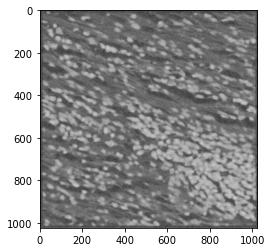

Actual Mask


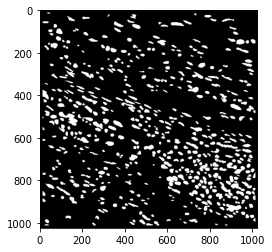

 10%|█         | 1/10 [00:08<01:12,  8.08s/it]

Train Epoch: 2 @ 09:53:12.790989 - Train Loss: 0.4509
Predicted Mask Sigmoid


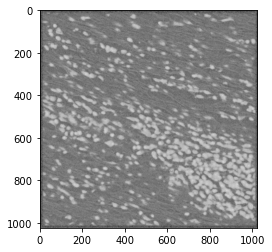

Actual Mask


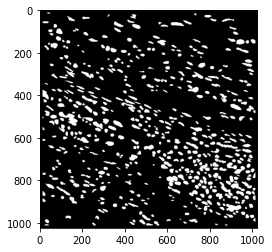

 20%|██        | 2/10 [00:15<01:03,  7.95s/it]

Train Epoch: 3 @ 09:53:20.395521 - Train Loss: 0.3955
Predicted Mask Sigmoid


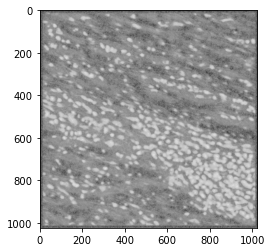

Actual Mask


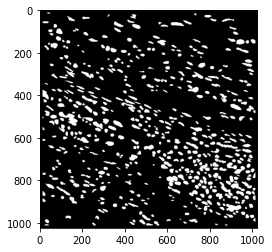

 30%|███       | 3/10 [00:23<00:54,  7.84s/it]

Train Epoch: 4 @ 09:53:27.985667 - Train Loss: 0.3488
Predicted Mask Sigmoid


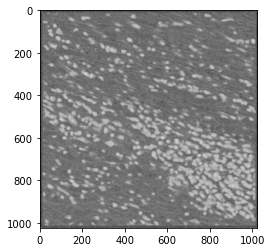

Actual Mask


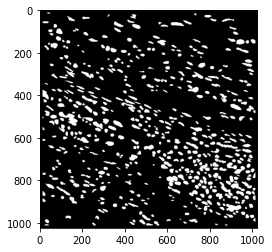

 40%|████      | 4/10 [00:30<00:46,  7.77s/it]

Train Epoch: 5 @ 09:53:35.505080 - Train Loss: 0.3195
Predicted Mask Sigmoid


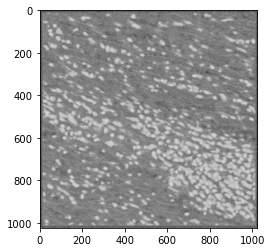

Actual Mask


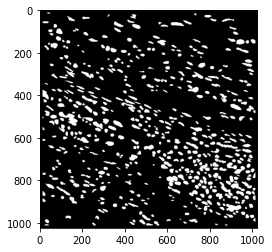

 50%|█████     | 5/10 [00:38<00:38,  7.71s/it]

Train Epoch: 6 @ 09:53:42.986054 - Train Loss: 0.2972
Predicted Mask Sigmoid


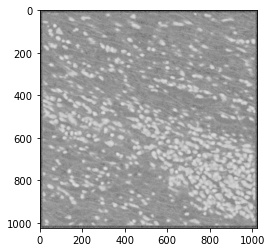

Actual Mask


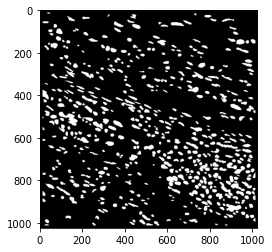

 60%|██████    | 6/10 [00:45<00:30,  7.62s/it]

Train Epoch: 7 @ 09:53:50.473093 - Train Loss: 0.2941
Predicted Mask Sigmoid


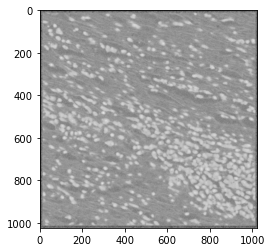

Actual Mask


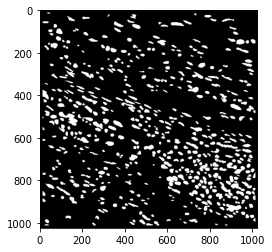

 70%|███████   | 7/10 [00:53<00:22,  7.58s/it]

Train Epoch: 8 @ 09:53:58.058757 - Train Loss: 0.2688
Predicted Mask Sigmoid


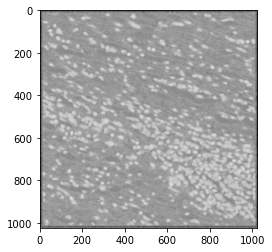

Actual Mask


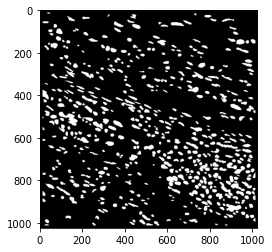

 80%|████████  | 8/10 [01:00<00:15,  7.59s/it]

Train Epoch: 9 @ 09:54:05.636913 - Train Loss: 0.2586
Predicted Mask Sigmoid


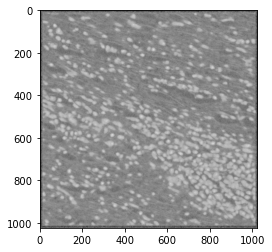

Actual Mask


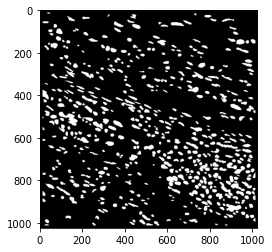

 90%|█████████ | 9/10 [01:08<00:07,  7.58s/it]

Train Epoch: 10 @ 09:54:13.123336 - Train Loss: 0.2543
Predicted Mask Sigmoid


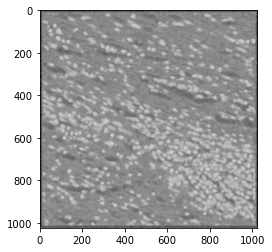

Actual Mask


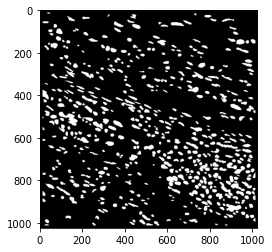

100%|██████████| 10/10 [01:16<00:00,  7.61s/it]


In [6]:
epochs = 10
train_losses = []

print("Training")
for epoch in tqdm(range(1, epochs + 1)):
    train_loss = train(model, device, train_dataloader, optimizer, epoch)
    train_losses.append(train_loss)

Input Image


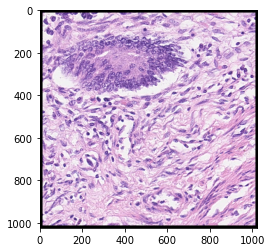

Predicted Mask Sigmoid


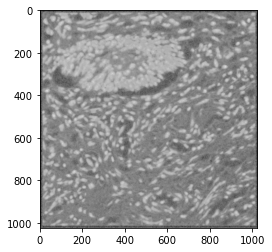

Predicted Mask Binary


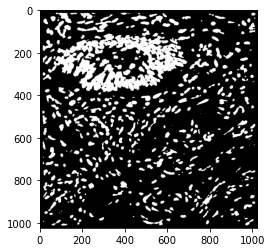

Actual Mask


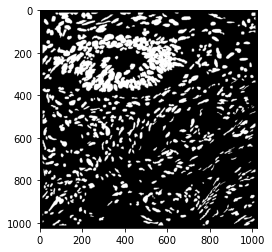

In [7]:
for data, target in test_dataloader:
    print("Input Image")
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    outputs = model(data.to(device))
    pred = outputs.to('cpu').detach().numpy()[0][0]

    print("Predicted Mask Sigmoid")
    plt.imshow(pred,cmap='gray')
    plt.show()
    threshold=0.95
    pred[pred >= threshold] = 1
    pred[pred < threshold] = 0
    print("Predicted Mask Binary")
    plt.imshow(pred,cmap='gray')
    plt.show()
    print("Actual Mask")
    plt.imshow(target[0],cmap='gray')
    plt.show()
    
    break